# SMS Spam Classification

## Imports

In [86]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix

## Read and clean data

In [3]:
data = pd.read_csv('spam.csv', encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


We see that there are 3 useless columns, we're going to delete them.

In [4]:
data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


We're going to rename 'v1' and 'v2' as 'label' and 'message' respectively, because that's more meaningful.

In [5]:
data.rename(columns={'v1': 'label', 'v2': 'message'}, inplace=True)
data.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


We check if there are any missing data.

In [6]:
data.count()  # check if the two columns have the same number of values

label      5572
message    5572
dtype: int64

In [7]:
data['label'].apply(len).min()  # check for empty labels

3

In [8]:
data['message'].apply(len).min()  # check for empty messages

2

In [9]:
set(data['label'])  # check if there are labels other than 'ham' and 'spam'

{'ham', 'spam'}

Apparently, there are no missing data. Before finishing this part, we'll transform the values of the 'label' column from 'ham' and 'spam' to 0 and 1 respectively.

In [10]:
data['label'] = data['label'].apply(lambda label: 0 if label == 'ham' else 1)
data.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


## Exploratory Data Analysis

In [10]:
data.describe()

,label
count,5572.000000
mean,0.134063
std,0.340751
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Percentage of spams: 13.41%


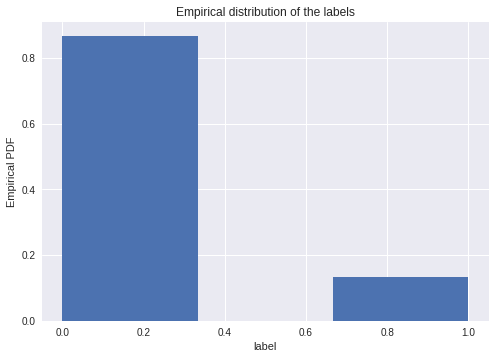

In [11]:
# Empirical distribution of the labels
print('Percentage of spams: {0}%'.format(round(100 * data['label'].sum() / len(data['label']), 2)))
plt.hist(data['label'], bins=3, weights=np.ones(len(data['label'])) / len(data['label']))
plt.xlabel('label')
plt.ylabel('Empirical PDF')
plt.title('Empirical distribution of the labels')

We see that the labels are unbalanced. 0 (ham) is highly represented wheras 1 (spam) represents only 13.41% of the data.

Since the classes (labels) are unbalanced, we cannot use accuracy to access the performance of the classifier that we'll build. A classifier which always returns 0 will have an accuracy around 87% (assuming the given data is well sampled). Instead, we'll use the F1-score because it takes into account the precision and recall of the system, which should be the case here.

Let's have a look at the messages now.

In [11]:
# extract spams and hams
spams = data['message'].iloc[(data['label'] == 1).values]
hams = data['message'].iloc[(data['label'] == 0).values]
print(spams[:10])
print(hams[:10])

2     Free entry in 2 a wkly comp to win FA Cup fina...
5     FreeMsg Hey there darling it's been 3 week's n...
8     WINNER!! As a valued network customer you have...
9     Had your mobile 11 months or more? U R entitle...
11    SIX chances to win CASH! From 100 to 20,000 po...
12    URGENT! You have won a 1 week FREE membership ...
15    XXXMobileMovieClub: To use your credit, click ...
19    England v Macedonia - dont miss the goals/team...
34    Thanks for your subscription to Ringtone UK yo...
42    07732584351 - Rodger Burns - MSG = We tried to...
Name: message, dtype: object
0     Go until jurong point, crazy.. Available only ...
1                         Ok lar... Joking wif u oni...
3     U dun say so early hor... U c already then say...
4     Nah I don't think he goes to usf, he lives aro...
6     Even my brother is not like to speak with me. ...
7     As per your request 'Melle Melle (Oru Minnamin...
10    I'm gonna be home soon and i don't want to tal...
13    I've been sea

We start seeing some caracteristics of spams, most notably the extensive use of the word 'Free'.

In [13]:
# message length
data['message_length'] = data['message'].apply(lambda message: len(message))
data.head()

,label,message,has_free,message_length
0,0,"Go until jurong point, crazy.. Available only ...",False,111
1,0,Ok lar... Joking wif u oni...,False,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,True,155
3,0,U dun say so early hor... U c already then say...,False,49
4,0,"Nah I don't think he goes to usf, he lives aro...",False,61


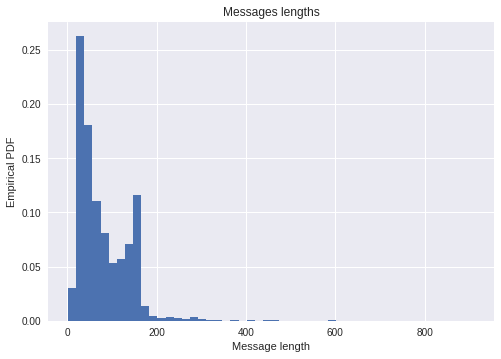

In [14]:
plt.hist(data['message_length'], bins=50, weights=np.ones(len(data))/len(data))
plt.xlabel('Message length')
plt.ylabel('Empirical PDF')
plt.title('Messages lengths')

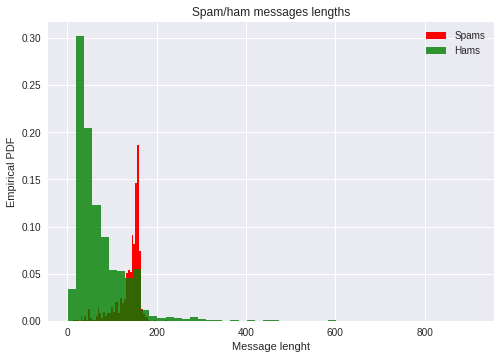

In [15]:
plt.hist(spams.apply(lambda x: len(x)),
         bins=50,
         weights=np.ones(len(spams)) / len(spams),
         facecolor='r',
         label='Spams')
plt.hist(hams.apply(lambda x: len(x)),
         bins=50,
         weights=np.ones(len(hams)) / len(hams),
         facecolor='g',
         alpha=0.8,
         label='Hams')
plt.xlabel('Message lenght')
plt.ylabel('Empirical PDF')
plt.title('Spam/ham messages lengths')
plt.legend()

We see that spams tend to be longer than hams. This information might be useful.

Now we'll look at which words are most common in spams and hams.

In [16]:
# most common words in spam and ham
spam_tokens = []
for spam in spams:
    spam_tokens += nltk.tokenize.word_tokenize(spam)
ham_tokens = []
for ham in hams:
    ham_tokens += nltk.tokenize.word_tokenize(ham)
print(spam_tokens[:10])
print(ham_tokens[:10])

['Free', 'entry', 'in', '2', 'a', 'wkly', 'comp', 'to', 'win', 'FA']
['Go', 'until', 'jurong', 'point', ',', 'crazy..', 'Available', 'only', 'in', 'bugis']


In [17]:
# remove stop words and puncuation from tokens
stop_words = ['.', 'to', '!', ',', 'a', '&', 
              'or', 'the', '?', ':', 'is', 'for',
              'and', 'from', 'on', '...', 'in', ';',
              'that', 'of']
for tokens in [spam_tokens, ham_tokens]:
    for stop_word in stop_words:
        try:
            while True:
                tokens.remove(stop_word)
        except ValueError:  # all occurrences of the stop word have been removed
            pass

In [18]:
most_common_tokens_in_spams = Counter(spam_tokens).most_common(20)
most_common_tokens_in_hams = Counter(ham_tokens).most_common(20)
print(most_common_tokens_in_spams)
print(most_common_tokens_in_hams)

[('you', 189), ('call', 187), ('your', 187), ('2', 176), ('now', 138), ('Call', 138), ('have', 129), ('FREE', 113), ('ur', 107), ('with', 102), ('4', 97), ('mobile', 95), ('U', 89), ('You', 81), ('claim', 78), ('are', 77), ('our', 76), ('Txt', 75), ('To', 74), ('prize', 73)]
[('I', 1910), ('you', 1697), ('i', 917), ('u', 716), ('me', 705), ('my', 622), ('it', 562), (')', 429), ("'s", 419), ("'m", 387), ('your', 375), ('do', 374), ('have', 366), ('not', 352), ("n't", 343), ('at', 338), ('are', 327), ('gt', 318), ('be', 316), ('lt', 316)]


Certain words like 'call' and 'free' seem to occurre often in the spams.

## Classification

Since we're maily dealing with text data (the messages), it makes sense to change the representation of the text, using either bag of words representations (tfidfs or word counts or binary BoW) or word embeddings. we'll use BoW representations, starting with tfidfs.

But before doing anything else, we'll split the data into train data and test data in order to have an accurate estimation of the final classifier's performance.

In [19]:
data, test_data = train_test_split(data, test_size=0.3)
print('Train-valid data length: {0}'.format(len(data)))
print('Test data length: {0}'.format(len(test_data)))

Train-valid data length: 3900
Test data length: 1672


In [20]:
binary_vectorizer = CountVectorizer(binary=True)
count_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()

In [50]:
def feature_extraction(df, test=False):
    if not test:
        tfidf_vectorizer.fit(df['message'])
    
    X = np.array(tfidf_vectorizer.transform(df['message']).todense())
    return X

In [73]:
train_df, valid_df = train_test_split(data, test_size=0.3)

X_train = feature_extraction(train_df)
y_train = train_df['label'].values

X_valid = feature_extraction(valid_df, test=True)
y_valid = valid_df['label'].values

In [74]:
clfs = {
    'mnb': MultinomialNB(),
    'gnb': GaussianNB(),
    'svm1': SVC(kernel='linear'),
    'svm2': SVC(kernel='rbf'),
    'svm3': SVC(kernel='sigmoid'),
    'mlp1': MLPClassifier(),
    'mlp2': MLPClassifier(hidden_layer_sizes=[100, 100]),
    'ada': AdaBoostClassifier(),
    'dtc': DecisionTreeClassifier(),
    'rfc': RandomForestClassifier(),
    'gbc': GradientBoostingClassifier(),
    'lr': LogisticRegression()
}

In [75]:
f1_scores = dict()
for clf_name in clfs:
    print(clf_name)
    clf = clfs[clf_name]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    f1_scores[clf_name] = f1_score(y_pred, y_valid)

mnb
gnb
svm1
svm2


/home/ghiles/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


svm3
mlp1
mlp2
ada
dtc
rfc
gbc
lr


In [76]:
f1_scores

{'ada': 0.88957055214723924,
 'dtc': 0.85106382978723394,
 'gbc': 0.87066246056782326,
 'gnb': 0.76410256410256416,
 'lr': 0.90445859872611467,
 'mlp1': 0.90445859872611467,
 'mlp2': 0.9119496855345911,
 'mnb': 0.94153846153846166,
 'rfc': 0.82191780821917804,
 'svm1': 0.90851735015772872,
 'svm2': 0.0,
 'svm3': 0.0}

Multinomial naive bayes seem to give the best results. Before doing hyperparameter optimization, we'll see how other BoW representations perform. We'll reduce the number of classifier to same some computation time.

In [77]:
clfs = {
    'mnb': MultinomialNB(),
    'gnb': GaussianNB(),
    'svm': SVC(kernel='linear'),
    'mlp': MLPClassifier(),
    'ada': AdaBoostClassifier(),
    'dtc': DecisionTreeClassifier(),
    'rfc': RandomForestClassifier(),
    'gbc': GradientBoostingClassifier(),
    'lr': LogisticRegression()
}

In [68]:
def feature_extraction(df, test=False):
    if not test:
        count_vectorizer.fit(df['message'])
    
    X = np.array(count_vectorizer.transform(df['message']).todense())
    return X

In [78]:
X_train = feature_extraction(train_df)
X_valid = feature_extraction(valid_df, test=True)

In [79]:
f1_scores = dict()
for clf_name in clfs:
    print(clf_name)
    clf = clfs[clf_name]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    f1_scores[clf_name] = f1_score(y_pred, y_valid)

mnb
gnb
svm
mlp
ada
dtc
rfc
gbc
lr


In [80]:
f1_scores

{'ada': 0.88957055214723924,
 'dtc': 0.83850931677018625,
 'gbc': 0.85714285714285721,
 'gnb': 0.76410256410256416,
 'lr': 0.90445859872611467,
 'mlp': 0.90793650793650793,
 'mnb': 0.94153846153846166,
 'rfc': 0.81099656357388306,
 'svm': 0.90851735015772872}

Multinomial naive bayes is still the best. The f1 score for it is the same.

Now, let's see with BoW.

In [81]:
def feature_extraction(df, test=False):
    if not test:
        binary_vectorizer.fit(df['message'])
    
    X = np.array(binary_vectorizer.transform(df['message']).todense())
    return X

In [83]:
X_train = feature_extraction(train_df)
X_valid = feature_extraction(valid_df, test=True)

In [84]:
f1_scores = dict()
for clf_name in clfs:
    print(clf_name)
    clf = clfs[clf_name]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    f1_scores[clf_name] = f1_score(y_pred, y_valid)

mnb
gnb
svm
mlp
ada
dtc
rfc
gbc
lr


In [85]:
f1_scores

{'ada': 0.88957055214723924,
 'dtc': 0.85970149253731354,
 'gbc': 0.87261146496815289,
 'gnb': 0.76410256410256416,
 'lr': 0.90445859872611467,
 'mlp': 0.90793650793650793,
 'mnb': 0.94153846153846166,
 'rfc': 0.81379310344827582,
 'svm': 0.90851735015772872}

Same results. I want to see how the binomial naive bayes performes.

In [87]:
clf = BernoulliNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)
f1_score(y_pred, y_valid)

0.84175084175084181

Not that good.

Conclusion: Multinomial naive bayes is the way to go.

Now, we'll see if we can do better by using message length.

In [98]:
def feature_extraction(df, test=False):
    if not test:
        count_vectorizer.fit(df['message'])
    
    X = np.array(count_vectorizer.transform(df['message']).todense())
    X = np.concatenate((X, df['message_length'].values.reshape(-1, 1)), axis=1)
    return X

In [99]:
X_train = feature_extraction(train_df)
X_valid = feature_extraction(valid_df, test=True)

In [100]:
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)
f1_score(y_pred, y_valid)

0.91482649842271302

It went down, we'll forget about it and work only with the word counts.

### Hyperparameter optimization

We'll only optimize the hyperparemeter alpha.

In [102]:
def feature_extraction(df, test=False):
    if not test:
        tfidf_vectorizer.fit(df['message'])
    
    X = np.array(tfidf_vectorizer.transform(df['message']).todense())
    return X

In [103]:
X_train = feature_extraction(train_df)
X_valid = feature_extraction(valid_df, test=True)

In [105]:
alpha_values = [i * 0.1 for i in range(11)]
max_f1_score = float('-inf')
best_alpha = None
for alpha in alpha_values:
    clf = MultinomialNB(alpha=alpha)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    current_f1_score = f1_score(y_pred, y_valid)
    if current_f1_score > max_f1_score:
        max_f1_score = current_f1_score
        best_alpha = alpha

/home/ghiles/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [107]:
print('Best alpha: {0}'.format(best_alpha))
print('Best f1-score: {0}'.format(max_f1_score))

Best alpha: 0.1
Best f1-score: 0.9345794392523363


## Final results

In [109]:
clf = MultinomialNB(alpha=0.1)

In [110]:
X_train = feature_extraction(data)
y_train = data['label'].values

X_test = feature_extraction(test_data, test=True)
y_test = test_data['label'].values

In [111]:
clf.fit(X_train, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [113]:
y_pred = clf.predict(X_test)
print('F1-score: {0}'.format(f1_score(y_pred, y_test)))
print('Confusion matrix:')
confusion_matrix(y_pred, y_test)

F1-score: 0.9264705882352942
Confusion matrix:


array([[1453,   28],
       [   2,  189]])

We obtained an f1-score of 0.92, which is pretty good for the task.